In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the Dataset

In [3]:
data=pd.read_csv("Test 1.csv")

In [4]:
data.head()

,customer_id,demographic_slice,country_reg,ad_exp,est_income,hold_bal,pref_cust_prob,imp_cscore,RiskScore,imp_crediteval,axio_score,card_offer
0,713782,AX03efs,W,N,33407.901749,3.000000,0.531112,619,503.249027,23.977827,0.137289,False
1,515901,AX03efs,E,N,19927.533533,20.257927,0.297439,527,820.108146,22.986398,0.052264,False
2,95166,AX03efs,W,Y,51222.470997,4.000000,0.018463,606,586.605795,24.939219,0.452035,False
3,425557,AX03efs,E,Y,67211.587467,18.653631,0.089344,585,634.701982,24.841147,0.564619,False
4,624581,AX03efs,W,N,20093.342158,4.000000,0.094948,567,631.949979,24.679363,0.917304,False


In [78]:
data.card_offer.value_counts() # imbalanced data

False    8469
True     1531
Name: card_offer, dtype: int64

## Encoding the data

In [19]:
country_reg=pd.get_dummies(data.country_reg,drop_first=True)
ad_exp=pd.get_dummies(data.ad_exp,drop_first=True)

In [20]:
data_dummified=data.drop(['card_offer','country_reg','ad_exp','demographic_slice','customer_id'],axis=1)


In [22]:
data_dummified=pd.concat((data_dummified,country_reg,ad_exp),axis=1)

In [24]:
X=data_dummified
y=data.card_offer

### Train Test Split

In [25]:
from sklearn.model_selection import train_test_split

In [49]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.30,random_state=0)

## Data is imbalanced
### Down-sampling will be used as the '1' means card_offer should be given which is important and is in minority

In [27]:
from sklearn.utils import resample

In [28]:
majority=data[data.card_offer==False]

In [29]:
minority=data[data.card_offer==True]

In [30]:
downsampled_majority= resample(majority,n_samples=len(minority),random_state=0)

In [31]:
data_downnsampled=pd.concat((downsampled_majority,minority))

In [32]:
data_downnsampled.card_offer.value_counts()

True     1531
False    1531
Name: card_offer, dtype: int64

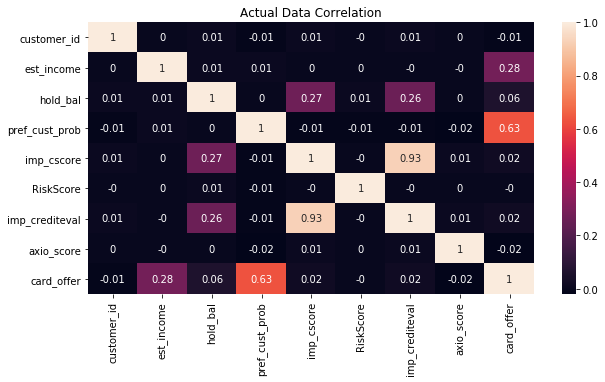

In [33]:
plt.figure(figsize=(10,5))
sns.heatmap(round(data.corr(),2),annot=True)
plt.title('Actual Data Correlation')
plt.show()


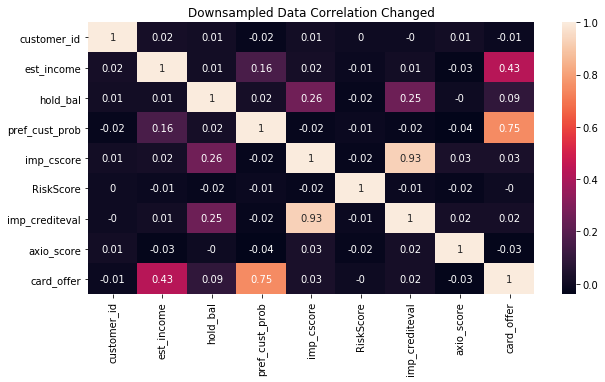

 Correlation of sample changed


In [34]:
plt.figure(figsize=(10,5))
sns.heatmap(round(data_downnsampled.corr(),2),annot=True)
plt.title('Downsampled Data Correlation Changed')
plt.show()
print(' Correlation of sample changed')

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold


In [36]:
ss=StratifiedKFold(n_splits=5,random_state=0)

In [37]:
for train_index, test_index in ss.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


TRAIN: [1848 1849 1850 ... 9997 9998 9999] TEST: [   0    1    2 ... 4057 4073 4094]
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [1848 1849 1850 ... 6025 6026 6038]
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [3658 3659 3660 ... 7305 7306 7310]
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [5588 5589 5592 ... 8630 8644 8645]
TRAIN: [   0    1    2 ... 8630 8644 8645] TEST: [7814 7815 7816 ... 9997 9998 9999]


## Using Near Miss Undersampling

In [38]:
from imblearn.under_sampling import NearMiss


In [50]:
nr = NearMiss()
X_train_downsampled, y_train_downsampled = nr.fit_sample(X_train, y_train)

In [51]:
X_train_downsampled=pd.DataFrame(X_train_downsampled,columns=data_dummified.columns)

In [55]:
y_train_downsampled=pd.DataFrame(y_train_downsampled,columns=['card_offer'])

In [58]:
y_train_downsampled.card_offer.value_counts()

True     1084
False    1084
Name: card_offer, dtype: int64

In [62]:
X_train.skew()

est_income       -0.546391
hold_bal          1.027108
pref_cust_prob    0.885937
imp_cscore        0.219001
RiskScore         0.016355
imp_crediteval    0.079298
axio_score        0.457851
W                -0.010860
Y                 0.008002
dtype: float64

In [61]:
X_train_downsampled.skew()

est_income       -1.756882
hold_bal          0.931222
pref_cust_prob    0.269725
imp_cscore        0.331387
RiskScore         0.019742
imp_crediteval    0.139722
axio_score        0.479961
W                 0.232337
Y                 0.024004
dtype: float64

# Without re-sampling
# Decision Tree

## With GINI impurity

In [63]:
from sklearn.tree import DecisionTreeClassifier

In [64]:
dt_gini=DecisionTreeClassifier(criterion='gini',random_state=0)

In [65]:
dt_gini.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

## Prediction and Evaluation

In [66]:
predicted_gini=dt_gini.predict(X_test)

In [67]:
import sklearn.metrics

In [68]:
print('Accuracy Score is',sklearn.metrics.accuracy_score(y_test,predicted_gini))

Accuracy Score is 0.9653333333333334


In [69]:
print('Classification Report \n',sklearn.metrics.classification_report(y_test,predicted_gini))

Classification Report 
               precision    recall  f1-score   support

       False       0.98      0.98      0.98      2553
        True       0.89      0.88      0.88       447

    accuracy                           0.97      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.97      0.97      0.97      3000



In [76]:
print('Confusion Matrix \n', sklearn.metrics.confusion_matrix(y_test,predicted_gini))

Confusion Matrix 
 [[2504   49]
 [  55  392]]


## With ENTROPY

In [70]:
dt_ent=DecisionTreeClassifier(criterion='entropy',random_state=0)

In [71]:
dt_ent.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

## Prediction and Evaluation

In [72]:
predicted_ent=dt_ent.predict(X_test)

In [73]:
print('Accuracy Score with Entropy',sklearn.metrics.accuracy_score(y_test,predicted_ent))

Accuracy Score with Entropy 0.9676666666666667


In [74]:
print('Classification Report \n',sklearn.metrics.classification_report(y_test,predicted_ent))

Classification Report 
               precision    recall  f1-score   support

       False       0.98      0.98      0.98      2553
        True       0.90      0.89      0.89       447

    accuracy                           0.97      3000
   macro avg       0.94      0.93      0.94      3000
weighted avg       0.97      0.97      0.97      3000



In [77]:
print('Confusion Matrix \n', sklearn.metrics.confusion_matrix(y_test,predicted_ent))

Confusion Matrix 
 [[2507   46]
 [  51  396]]


## With Under-Sampling

### With GINI

In [79]:
dt_gini=DecisionTreeClassifier(criterion='gini',random_state=0)

In [80]:
dt_gini.fit(X_train_downsampled,y_train_downsampled)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

## Prediction and Evaluation

In [81]:
predicted_gini_sm=dt_gini.predict(X_test)

In [84]:
print('Accuracy Score is',sklearn.metrics.accuracy_score(y_test,predicted_gini_sm))

Accuracy Score is 0.8973333333333333


In [83]:
print('Classification Report \n',sklearn.metrics.classification_report(y_test,predicted_gini_sm))

Classification Report 
               precision    recall  f1-score   support

       False       0.99      0.89      0.94      2553
        True       0.60      0.95      0.73       447

    accuracy                           0.90      3000
   macro avg       0.79      0.92      0.84      3000
weighted avg       0.93      0.90      0.91      3000



In [86]:
print('Confusion Matrix \n', sklearn.metrics.confusion_matrix(y_test,predicted_gini_sm))

Confusion Matrix 
 [[2267  286]
 [  22  425]]


### With Entropy

In [87]:
dt_ent=DecisionTreeClassifier(criterion='entropy',random_state=0)

In [88]:
dt_ent.fit(X_train_downsampled,y_train_downsampled)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

## Prediction and Evaluation

In [89]:
predicted_ent_sm=dt_ent.predict(X_test)

In [90]:
print('Accuracy Score with Entropy',sklearn.metrics.accuracy_score(y_test,predicted_ent_sm))

Accuracy Score with Entropy 0.893


In [91]:
print('Classification Report \n',sklearn.metrics.classification_report(y_test,predicted_ent_sm))

Classification Report 
               precision    recall  f1-score   support

       False       0.99      0.88      0.93      2553
        True       0.59      0.95      0.73       447

    accuracy                           0.89      3000
   macro avg       0.79      0.92      0.83      3000
weighted avg       0.93      0.89      0.90      3000



In [92]:
print('Confusion Matrix \n', sklearn.metrics.confusion_matrix(y_test,predicted_ent_sm))

Confusion Matrix 
 [[2253  300]
 [  21  426]]


## Comparing the confusion matrix

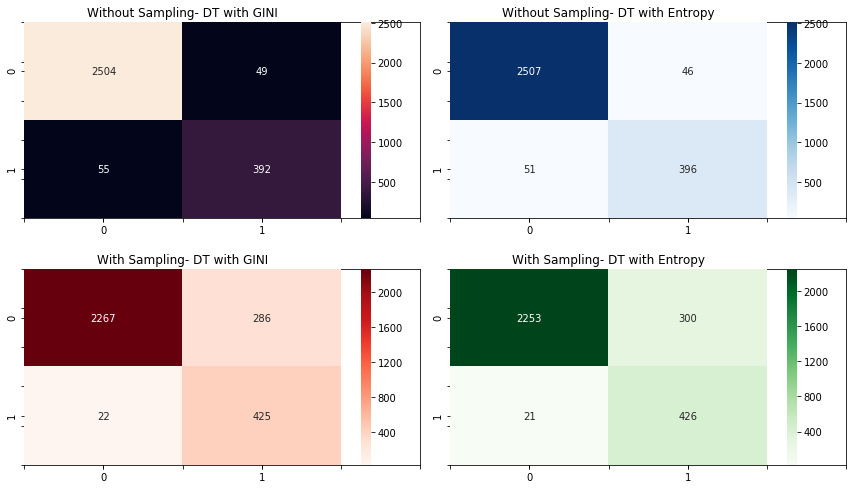

In [157]:
fig,ax=plt.subplots(2,2,figsize=(12,7))
ax1=fig.add_subplot(2,2,1)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,predicted_gini),annot=True,fmt='d')
ax1.set_title('Without Sampling- DT with GINI')

ax2=fig.add_subplot(2,2,2)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,predicted_ent),annot=True,fmt='d',cmap='Blues')
ax2.set_title('Without Sampling- DT with Entropy')


ax3=fig.add_subplot(2,2,3)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,predicted_gini_sm),annot=True,fmt='d',cmap='Reds')
ax3.set_title('With Sampling- DT with GINI')


ax4=fig.add_subplot(2,2,4)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,predicted_ent_sm),annot=True,fmt='d',cmap='Greens')
ax4.set_title('With Sampling- DT with Entropy')


ax[0,0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0,0].set_yticklabels(['', ''], fontsize=14, rotation=360)
ax[0, 1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 1].set_yticklabels(['', ''], fontsize=14, rotation=360)
ax[1, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)
ax[1, 1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1, 1].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.tight_layout()
plt.show()

 ## Using SMOTE Sampling Technique

In [132]:
from imblearn.over_sampling import SMOTE

In [133]:
smote=SMOTE(ratio='minority',random_state=0)

In [134]:
X_train_smote,y_train_smote=smote.fit_sample(X_train,y_train)

In [137]:
X_train_smote=pd.DataFrame(X_train_smote,columns=X_train.columns)

## DT with GINI 

In [149]:
dt_gini=DecisionTreeClassifier(criterion='gini',random_state=0)

In [150]:
dt_gini.fit(X_train_smote,y_train_smote)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

### Prediction and Evaluation

In [151]:
predicted_gini_smote=dt_gini.predict(X_test)

In [153]:
print('Accuracy Score with Gini',sklearn.metrics.accuracy_score(y_test,predicted_gini_smote))
print('\n')
print('Classification Report \n',sklearn.metrics.classification_report(y_test,predicted_gini_smote))
print('\n')
print('Confusion Matrix \n', sklearn.metrics.confusion_matrix(y_test,predicted_gini_smote))

Accuracy Score with Gini 0.966


Classification Report 
               precision    recall  f1-score   support

       False       0.98      0.98      0.98      2553
        True       0.88      0.90      0.89       447

    accuracy                           0.97      3000
   macro avg       0.93      0.94      0.93      3000
weighted avg       0.97      0.97      0.97      3000



Confusion Matrix 
 [[2496   57]
 [  45  402]]


## DT with Entropy

In [145]:
dt_ent=DecisionTreeClassifier(criterion='entropy',random_state=0)

In [146]:
dt_ent.fit(X_train_smote,y_train_smote)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

### Prediction and Evaluation

In [147]:
predicted_ent_smote=dt_ent.predict(X_test)

In [148]:
print('Accuracy Score with Entropy',sklearn.metrics.accuracy_score(y_test,predicted_ent_smote))
print('\n')
print('Classification Report \n',sklearn.metrics.classification_report(y_test,predicted_ent_smote))
print('\n')
print('Confusion Matrix \n', sklearn.metrics.confusion_matrix(y_test,predicted_ent_smote))


Accuracy Score with Entropy 0.9646666666666667


Classification Report 
               precision    recall  f1-score   support

       False       0.98      0.98      0.98      2553
        True       0.87      0.89      0.88       447

    accuracy                           0.96      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.97      0.96      0.96      3000



Confusion Matrix 
 [[2495   58]
 [  48  399]]


In [162]:
np.bincount(y_train_smote)

array([5916, 5916], dtype=int64)

# Random Forest Classifier

## Without Sampling

In [163]:
from sklearn.ensemble import RandomForestClassifier

In [164]:
rf=RandomForestClassifier(n_estimators=100,criterion='entropy')

In [165]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Prediction and Evaluation

In [166]:
predicted_ent_rf=rf.predict(X_test)

In [167]:
print('The accuracy score is', sklearn.metrics.accuracy_score(y_test,predicted_ent_rf))

The accuracy score is 0.98


In [168]:
print('Classification Report', sklearn.metrics.classification_report(y_test,predicted_ent_rf))

Classification Report               precision    recall  f1-score   support

       False       0.98      0.99      0.99      2553
        True       0.95      0.91      0.93       447

    accuracy                           0.98      3000
   macro avg       0.97      0.95      0.96      3000
weighted avg       0.98      0.98      0.98      3000



In [169]:
print('Confusion Matrix \n',sklearn.metrics.confusion_matrix(y_test,predicted_ent_rf))

Confusion Matrix 
 [[2532   21]
 [  39  408]]


## With Downsampling

In [190]:
rf=RandomForestClassifier(n_estimators=100,criterion='entropy')

In [191]:
rf.fit(X_train_downsampled,y_train_downsampled)

C:\Users\Vimesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [192]:
predicted_rf_downsampled=rf.predict(X_test)

In [193]:
print('Accuracy Score with Entropy',sklearn.metrics.accuracy_score(y_test,predicted_rf_downsampled))
print('\n')
print('Classification Report \n',sklearn.metrics.classification_report(y_test,predicted_rf_downsampled))
print('\n')
print('Confusion Matrix \n', sklearn.metrics.confusion_matrix(y_test,predicted_rf_downsampled))


Accuracy Score with Entropy 0.8713333333333333


Classification Report 
               precision    recall  f1-score   support

       False       1.00      0.85      0.92      2553
        True       0.54      0.98      0.69       447

    accuracy                           0.87      3000
   macro avg       0.77      0.92      0.81      3000
weighted avg       0.93      0.87      0.89      3000



Confusion Matrix 
 [[2176  377]
 [   9  438]]


## Hyperparameter Tuning

### Downsampled data

In [170]:
from sklearn.model_selection import GridSearchCV

In [176]:
rf=RandomForestClassifier(random_state=0)

In [175]:
params={'criterion':['gini','entropy'],'max_depth':[2,3,4,6], 'max_features':['auto', 'sqrt', 'log2', None], 'bootstrap':[True,False]}

In [180]:
cv_rf=GridSearchCV(rf,param_grid=params,cv=10, n_jobs=1)

In [179]:
import time

In [181]:
start= time.time()


cv_rf.fit(X_train_downsampled,y_train_downsampled)


end= time.time()

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in 

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in 

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in 

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in 

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in 

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in 

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

In [182]:
print('Best Parameters using grid search: \n', cv_rf.best_params_)
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'max_features': None}
Time taken in grid search:  53.15


In [183]:
rf=RandomForestClassifier(random_state=0,bootstrap=True, criterion='entropy',max_depth=6, max_features= None)

In [184]:
rf.fit(X_train_downsampled,y_train_downsampled)

C:\Users\Vimesh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vimesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [186]:
predicted_rf_down_Grids=rf.predict(X_test)

In [187]:
print('Accuracy Score is', sklearn.metrics.accuracy_score(y_test,predicted_rf_down_Grids))

Accuracy Score is 0.8823333333333333


In [188]:
print('Classification Report', sklearn.metrics.classification_report(y_test,predicted_rf_down_Grids))

Classification Report               precision    recall  f1-score   support

       False       1.00      0.87      0.93      2553
        True       0.56      0.98      0.71       447

    accuracy                           0.88      3000
   macro avg       0.78      0.92      0.82      3000
weighted avg       0.93      0.88      0.89      3000



In [189]:
print('Confusion Matrix \n',sklearn.metrics.confusion_matrix(y_test,predicted_rf_down_Grids))

Confusion Matrix 
 [[2210  343]
 [  10  437]]


# Comparing Confusion Matrices for Random Forest Classifier

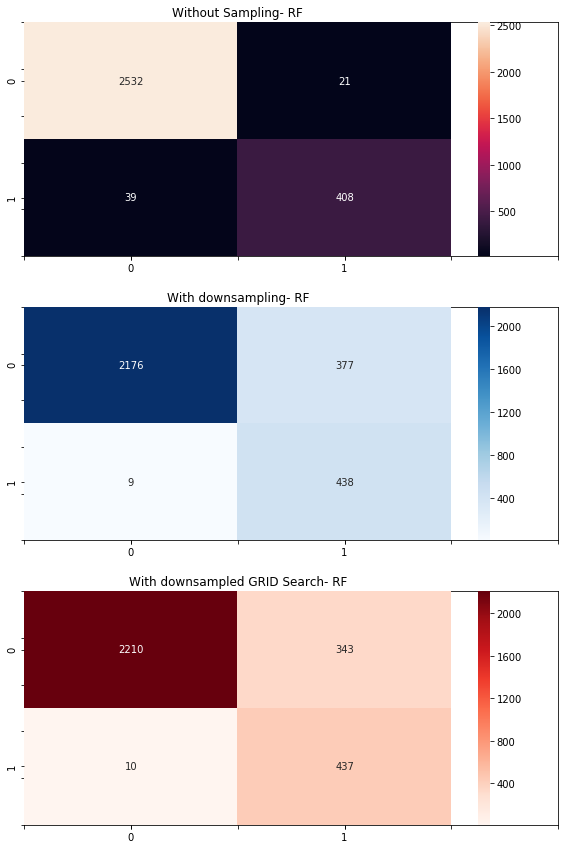

In [201]:
fig,ax=plt.subplots(3,1,figsize=(8,12))
ax1=fig.add_subplot(3,1,1)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,predicted_ent_rf),annot=True,fmt='d')
ax1.set_title('Without Sampling- RF')

ax2=fig.add_subplot(3,1,2)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,predicted_rf_downsampled),annot=True,fmt='d',cmap='Blues')
ax2.set_title('With downsampling- RF')


ax3=fig.add_subplot(3,1,3)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test,predicted_rf_down_Grids),annot=True,fmt='d',cmap='Reds')
ax3.set_title('With downsampled GRID Search- RF')




ax[1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1].set_yticklabels(['', ''], fontsize=14, rotation=360)
ax[0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0].set_yticklabels(['', ''], fontsize=14, rotation=360)
ax[2].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.tight_layout()
plt.show()